In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.integrate import solve_ivp
font = {'weight' : 'normal', 'size'   : 20}
matplotlib.rc('font', **font)

import os

In [2]:
array_colors = ["black", "green", "blue", "orange", "purple", "black"]

In [3]:
def shear_nondim(time, amp, oscillatory):
    if oscillatory:
        return amp * np.sin(time / amp)
    return amp

def shear_rate_nondim(time, amp, oscillatory):
    if oscillatory:
        return np.cos(time / amp)
    return 1

def shear_rate_rate_nondim(time, amp, oscillatory):
    if oscillatory:
        return - (1 / amp) * np.sin(time / amp)
    return 0

In [4]:
def second_inv_nondim(time, amp, oscillatory):
    return np.abs(np.sqrt(2) * shear_rate_nondim(time, amp, oscillatory))

def s_nondim(time, Bi, beta, n, reg, amp, oscillatory):

    second_inv = second_inv_nondim(time, amp, oscillatory)
    yield_stress_term = (Bi / (second_inv + reg))

    if n < 1.0:
        HB_term = (beta * second_inv ** n) / (second_inv + reg)
    else:
        HB_term = beta * (second_inv ** (n - 1))

    return yield_stress_term + HB_term

def relaxation_time_nondim(time, Bi, beta, n, reg, amp, oscillatory):

    s = s_nondim(time, Bi, beta, n, reg, amp, oscillatory)
    return s + 1

def eta_N_nondim(time, Bi, beta, n, reg, amp, oscillatory):

    s = s_nondim(time, Bi, beta, n, reg, amp, oscillatory)
    relaxation_time = relaxation_time_nondim(time, Bi, beta, n, reg, amp, oscillatory)

    return s / (relaxation_time + reg)

def second_inv_deriv_nondim(time, amp, oscillatory):
    shear_rate = shear_rate_nondim(time, amp, oscillatory)
    shear_rate_rate = shear_rate_rate_nondim(time, amp, oscillatory)

    return np.sqrt(2) * np.sign(shear_rate) * shear_rate_rate

def eta_N_deriv_nondim(time, Bi, beta, n, reg, amp, oscillatory):

    s = s_nondim(time, Bi, beta, n, reg, amp, oscillatory)
    relaxation_time = relaxation_time_nondim(time, Bi, beta, n, reg, amp, oscillatory)

    second_inv = second_inv_nondim(time, amp, oscillatory)
    second_inv_deriv = second_inv_deriv_nondim(time, amp, oscillatory)

    if n < 2:
        return ((1 / (relaxation_time + reg)) - ((1 / (relaxation_time ** 2 + reg)) * s)) * (((-Bi + beta * (n - 1) * second_inv ** n)) / (second_inv ** 2 + reg)) * second_inv_deriv

    return ((1 / (relaxation_time + reg)) - ((1 / (relaxation_time ** 2 + reg)) * s)) * ((-Bi / (second_inv ** 2 + reg)) + (beta * (n - 1) * second_inv ** (n - 2))) * second_inv_deriv

def eta_p_nondim(time, Wi, Bi, beta, n, reg, amp, oscillatory):

    s = s_nondim(time, Bi, beta, n, reg, amp, oscillatory)
    relaxation_time = relaxation_time_nondim(time, Bi, beta, n, reg, amp, oscillatory)

    eta_N = eta_N_nondim(time, Bi, beta, n, reg, amp, oscillatory)
    eta_N_deriv = eta_N_deriv_nondim(time, Bi, beta, n, reg, amp, oscillatory)

    return s - eta_N - Wi * relaxation_time * eta_N_deriv

In [5]:
def ode_rhs_split_nondim(time, tau, reg, oscillatory, Wi, Bi, beta, n, amp):
    txx = tau[0]
    txy = tau[1]

    shear_rate = shear_rate_nondim(time, amp, oscillatory)

    relaxation_time = relaxation_time_nondim(time, Bi, beta, n, reg, amp, oscillatory)
    eta_p = eta_p_nondim(time, Wi, Bi, beta, n, reg, amp, oscillatory)

    lambda_p = Wi * relaxation_time

    rhs_txx = 2.0 * shear_rate * txy - (txx / (lambda_p + reg))
    rhs_txy = (eta_p * shear_rate - txy) / (lambda_p + reg)

    return np.array( [rhs_txx, rhs_txy])

def ode_rhs_full_nondim(time, tau, reg, oscillatory, Wi, Bi, beta, n, amp):
    txx = tau[0]
    txy = tau[1]

    shear_rate = shear_rate_nondim(time, amp, oscillatory)
    shear_rate_rate = shear_rate_rate_nondim(time, amp, oscillatory)

    s = s_nondim(time, Bi, beta, n, reg, amp, oscillatory)
    relaxation_time = relaxation_time_nondim(time, Bi, beta, n, reg, amp, oscillatory)

    lambda_p = Wi * relaxation_time

    rhs_txx = 2.0 * shear_rate * txy - (txx + 2.0 * s * Wi * shear_rate ** 2) / (lambda_p + reg)
    rhs_txy = (s * (shear_rate + Wi * shear_rate_rate) - txy) / (lambda_p + reg)

    return np.array( [rhs_txx, rhs_txy])


In [6]:
parameters = [r"$Wi$", r"$Bi$", r"$\beta$", r"$n$", r"$\epsilon$"]

linestyles = ["-", "--", "dotted"]

In [7]:
def plot_full_and_split(Wi, Bi, beta, n, reg, oscillatory, amp, decs=3):
    fig, ax = plt.subplots(2, 1, figsize=(12, 9))
    ax_txy = ax[0]
    ax_txx = ax[1]

    tMin = 0
    tMax = 1 * 2 * np.pi
    t_eval = np.linspace(tMin, tMax, 100)

    array_shear_rate = shear_rate_nondim(t_eval, amp, oscillatory)

    eta_N_array = eta_N_nondim(t_eval, Bi, beta, n, reg, amp, oscillatory)
    eta_N_init = eta_N_array[0] if oscillatory else eta_N_array
    shear_rate_init = array_shear_rate[0] if oscillatory else array_shear_rate

    solution_full = solve_ivp(ode_rhs_full_nondim, [0.0, tMax], [0.0, eta_N_init * shear_rate_init], t_eval=t_eval, args = ([reg, oscillatory, Wi, Bi, beta, n, amp]))

    solution_split = solve_ivp(ode_rhs_split_nondim, [0.0, tMax], [0.0, 0.0], t_eval=t_eval, args = ([reg, oscillatory, Wi, Bi, beta, n, amp]))

    ax_txx.plot(solution_full.t, solution_full.y[0], ls = "-", color = "k", label="Full")
    ax_txx.plot(solution_split.t, solution_split.y[0], "o", color = "k", label="Split")

    solution_split_total = solution_split.y[1] + eta_N_array * array_shear_rate
    ax_txy.plot(solution_full.t, solution_full.y[1], ls = "-", color = "k", label="Full")
    ax_txy.plot(solution_split.t, solution_split_total, "o", color = "k", label="Split")

    ax_txx.legend(loc=4)
    # ax_txy.legend()

    ax_txy.set_xlim([tMin, tMax])
    # ax_txy.set_ylim(ymin=0)
    ax_txy.set_xlabel(r"Time: $t$ [nondim]")
    ax_txy.set_ylabel(r"Stress: $T_{xy}$ [nondim]")

    ax_txx.set_xlim([tMin, tMax])
    # ax_txx.set_ylim(ymin=0)
    ax_txx.set_xlabel(r"Time: $t$ [nondim]")
    ax_txx.set_ylabel(r"Stress: $T_{xx}$ [nondim]")

    if oscillatory:
        figtitle = fr"$Wi$ = {Wi:.{decs}f}, $Bi$ = {Bi:.{decs}f}, $\beta$ = {beta:.{decs}f}, $n$ = {n:.{decs}f}, $\epsilon$ = {reg}, $\gamma_0$ = {amp}"
    else:
        figtitle = fr"$Wi$ = {Wi:.{decs}f}, $Bi$ = {Bi:.{decs}f}, $\beta$ = {beta:.{decs}f}, $n$ = {n:.{decs}f}, $\epsilon$ = {reg}, " + r"$\dot{\gamma}_0$" + f" = {amp}"


    plt.suptitle(f"{figtitle}")

    fig.tight_layout()
    plt.show()

In [8]:
def calculate_params(eta_s, gamma_0, omega, G, tau_y, k, n, decs=3):
    Wi = round((eta_s * gamma_0 * omega) / G, decs)
    Bi = round(tau_y / (eta_s * gamma_0 * omega), decs)
    beta = round((k * (gamma_0 * omega) ** (n - 1)) / eta_s, decs)

    print(f"Wi = {Wi}, Bi = {Bi}, beta = {beta}")
    return Wi, Bi, beta

Wi = 0.03, Bi = 7.272, beta = 1.7


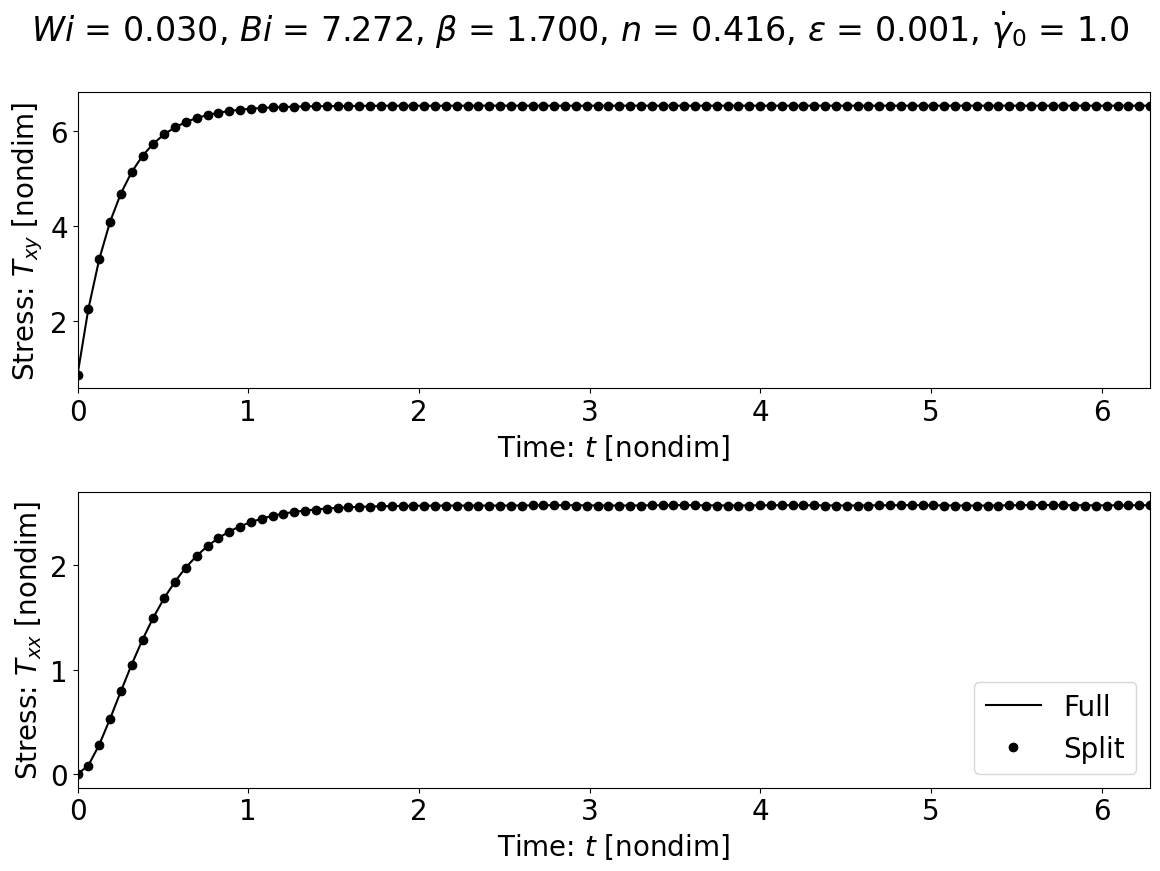

In [9]:
G = 430
eta_s = 23
tau_y = 94
k = 27.93
n = 0.416
gamma_0 = 1
omega = 0.562

Wi, Bi, beta = calculate_params(eta_s, gamma_0, omega, G, tau_y, k, n)

# Wi = Wi * 10

reg = 1e-3
oscillatory = False

amp = 1.0

plot_full_and_split(Wi, Bi, beta, n, reg, oscillatory, amp)

In [10]:
def plot_param_variations(param_no, param_array, other_params, oscillatory, amp, num_periods):
    fig, ax = plt.subplots(2, 1, figsize=(12, 9))
    ax_txy = ax[0]
    ax_txx = ax[1]

    tMin = 0
    tMax = num_periods * 2 * np.pi
    t_eval = np.linspace(tMin, tMax, 1000)

    for i_X, X in enumerate(param_array):
        print(fr"Processing data for {parameters[param_no]} = {X}")

        input_params = other_params.copy()

        input_params.insert(param_no, X)

        # Model parameters
        Wi = input_params[0]
        Bi = input_params[1]
        beta = input_params[2]
        n = input_params[3]
        reg = input_params[4]

        array_shear_rate = shear_rate_nondim(t_eval, amp, oscillatory)

        eta_N_array = eta_N_nondim(t_eval, Bi, beta, n, reg, amp, oscillatory)

        solution_split = solve_ivp(ode_rhs_split_nondim, [0.0, tMax], [0.0, 0.0], t_eval=t_eval, args = ([reg, oscillatory, Wi, Bi, beta, n, amp]))

        ax_txx.plot(solution_split.t, solution_split.y[0], label = f"{parameters[param_no]} = {X}", ls = linestyles[i_X], color='k')

        solution_split_total = solution_split.y[1] + eta_N_array * array_shear_rate
        # ax_txy.plot(solution_split.t, solution_split_total, label = f"{parameters[param_no]} = {X}", ls = linestyles[i_X], color='k')
        ax_txy.plot(solution_split.t, solution_split.y[1], label = f"{parameters[param_no]} = {X}", ls = linestyles[i_X], color='k')
        # ax_txy.plot(solution_split.t, solution_split_total, label = f"{parameters[param_no]} = {X}", ls = linestyles[i_X], color='k')
        # ax_txy.plot(solution_split.t, solution_split_total, label = f"{parameters[param_no]} = {X}", ls = linestyles[i_X], color='k')

    ax_txx.legend(loc=4)
    # ax_txy.legend()

    ax_txy.set_xlim([tMin, tMax])
    # ax_txy.set_ylim(ymin=0)
    ax_txy.set_xlabel(r"Time: $t$ [nondim]")
    ax_txy.set_ylabel(r"Stress: $T_{p, xy}$ [nondim]")

    ax_txx.set_xlim([tMin, tMax])
    # ax_txx.set_ylim(ymin=0)
    ax_txx.set_xlabel(r"Time: $t$ [nondim]")
    ax_txx.set_ylabel(r"Stress: $T_{p, xx}$ [nondim]")

    figtitle = ""
    for i, param in enumerate(parameters):
        if i != param_no:
            figtitle += f"{param} = {input_params[i]}, "
    figtitle = figtitle[:-2]


    plt.suptitle(f"{figtitle}")

    fig.tight_layout()
    plt.show()

Wi = 0.03, Bi = 7.272, beta = 1.7
Processing data for $Wi$ = 0.1
Processing data for $Wi$ = 0.5
Processing data for $Wi$ = 1


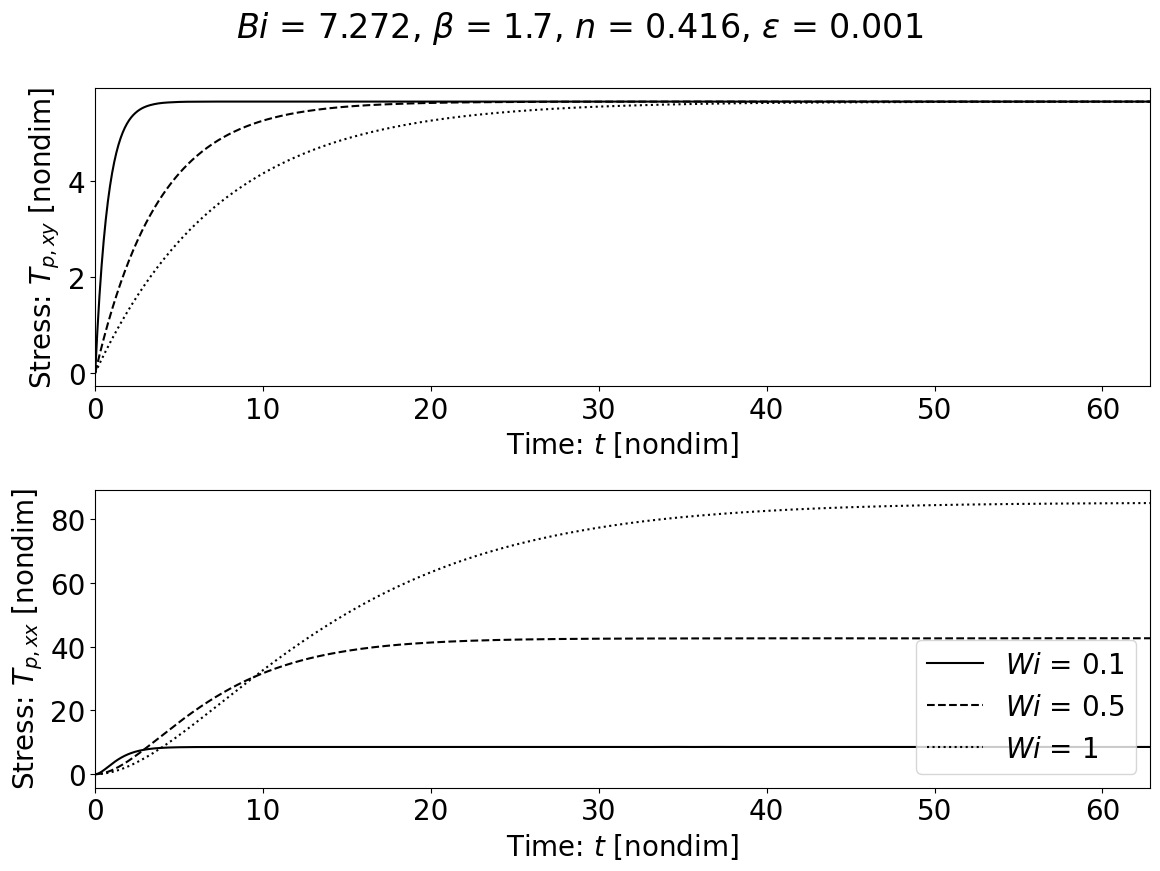

In [11]:
G = 430
eta_s = 23
tau_y = 94
k = 27.93
n = 0.416
gamma_0 = 1
omega = 0.562

Wi, Bi, beta = calculate_params(eta_s, gamma_0, omega, G, tau_y, k, n)

list_Wi = [0.1, 0.5, 1]
eps = 1e-3

param_no = 0

oscillatory = False
amp = 1

num_periods = 10

plot_param_variations(param_no, list_Wi, [Bi, beta, n, eps], oscillatory, amp, num_periods)

In [12]:
def plotting(Re, reg, oscillatory, Wi, Bi, beta, n, amp, base_folder, analytical_indicator, num_periods, decs=3):
	num_plots = 2
	plot_height = 9
	fig, ax = plt.subplots(num_plots, 1, figsize=(12, plot_height))
	ax_txy = ax[0]
	ax_txx = ax[1]

	# === Exact solution
	tMin = 0.0001
	tMax = num_periods * 2 * np.pi
	t_eval = np.linspace(tMin, tMax, 10000)

	t_plot = np.linspace(tMin, tMax, 100)

	input_Wi = round(Wi * amp, decs)
	input_Bi = round(Bi / amp, decs)
	input_beta = round(beta * amp ** (n - 1), decs)
	
	solution = solve_ivp(ode_rhs_split_nondim, [0.0, tMax], [0.0, 0.0], t_eval=t_eval, args = ([reg, oscillatory, input_Wi, input_Bi, input_beta, n, amp]))
	ax_txx.plot(solution.t, solution.y[0], color=array_colors[0], label = "Analytical")
	ax_txy.plot(solution.t, solution.y[1], color=array_colors[0], label = "Analytical")

	# Selecting some equally spaced points in the log scale
	def find_nearest(x):
		difference_array = np.absolute(array_t - x)
		return difference_array.argmin() #returns the index

	# Numerical solution
	if oscillatory:
		simulation_folder = "oscillatory_reg%g_Wi%g_Bi%g_beta%g_n%g_Re%g_amp%g_an%g/" % (reg, input_Wi, input_Bi, input_beta, n, Re, amp, analytical_indicator)
	else:
		simulation_folder = "startup_reg%g_Wi%g_Bi%g_beta%g_n%g_Re%g_amp%g_an%g/" % (reg, input_Wi, input_Bi, input_beta, n, Re, amp, analytical_indicator)
	
	file_name = base_folder + simulation_folder + "log_file.txt"
	file_data = np.loadtxt(file_name)
	array_t = file_data[:, 1]
	array_txx = file_data[:, 3]
	array_txy = file_data[:, 4]
	array_tyy = file_data[:, 5]
	
	selected_indices = np.array( list(map( find_nearest, t_plot )) )
	array_t = array_t[selected_indices]
	array_txx = array_txx[selected_indices]
	array_txy = array_txy[selected_indices]
	array_tyy = array_tyy[selected_indices]
	ax_txx.plot(array_t, array_txx, 'o', color=array_colors[0], fillstyle="none", label = "Basilisk")
	ax_txy.plot(array_t, array_txy, 'o', color=array_colors[0], fillstyle="none", label = "Basilisk")

	tMax_plot = tMax
	ax_txy.set_xlim([tMin, tMax_plot])
	ax_txy.set_xlabel(r"Time: $t$ [nondim]")
	ax_txy.set_ylabel(r"Stress: $T_{p, xy}$ [nondim]")
	ax_txy.legend()

	ax_txx.set_xlim([tMin, tMax_plot])
	ax_txx.set_xlabel(r"Time: $t$ [nondim]")
	ax_txx.set_ylabel(r"Stress: $T_{p, xx}$ [nondim]")

	if oscillatory:
		plt.suptitle(rf"$Wi$ = {input_Wi}, $Bi$ = {input_Bi}, $\beta$ = {input_beta}, $n$ = {n}, $Re$ = {Re}, $\gamma_0$ = {amp}, $\epsilon$ = {reg}")
	else:
		plt.suptitle(rf"$Wi$ = {input_Wi}, $Bi$ = {input_Bi}, $\beta$ = {input_beta}, $n$ = {n}, $Re$ = {Re}, " + r"$\dot{\gamma}_0$" + fr" = {amp}, $\epsilon$ = {reg}")
	fig.tight_layout()
	plt.show()

Wi = 0.03, Bi = 7.272, beta = 1.7


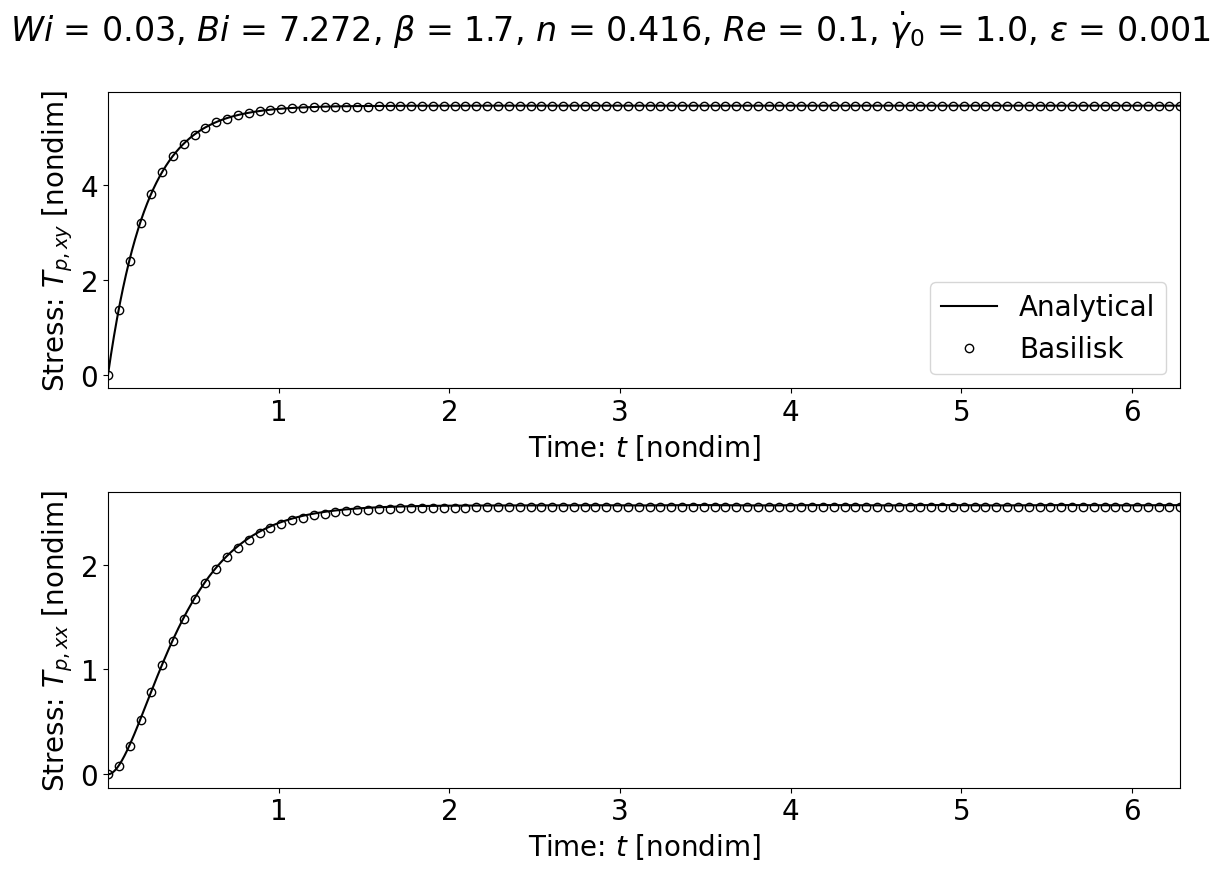

In [13]:
G = 430
eta_s = 23
tau_y = 94
k = 27.93
n = 0.416
gamma_0 = 1
omega = 0.562

Wi, Bi, beta = calculate_params(eta_s, gamma_0, omega, G, tau_y, k, n)

Re = 0.1
reg = 1e-3
oscillatory = False
analytical_indicator = 0

amp = 1.0

base_folder = os.path.curdir + "/outputs/"

num_periods = 1

plotting(Re, reg, oscillatory, Wi, Bi, beta, n, amp, base_folder, analytical_indicator, num_periods)

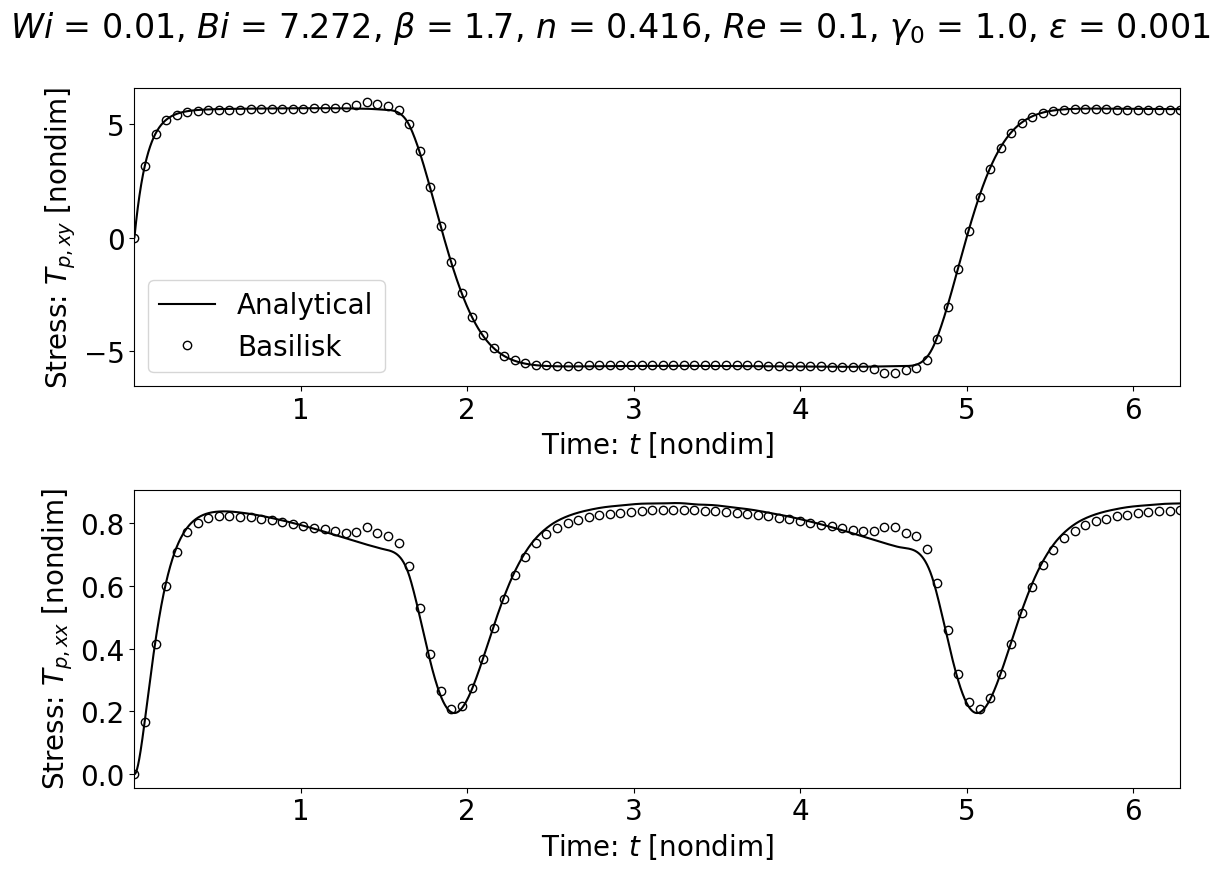

In [14]:
Wi = 0.01
Bi = 7.272
beta = 1.7
n = 0.416

Re = 0.1
reg = 1e-3
oscillatory = True
analytical_indicator = 0

amp = 1.0

base_folder = os.path.curdir + "/outputs/"

num_periods = 1

plotting(Re, reg, oscillatory, Wi, Bi, beta, n, amp, base_folder, analytical_indicator, num_periods)

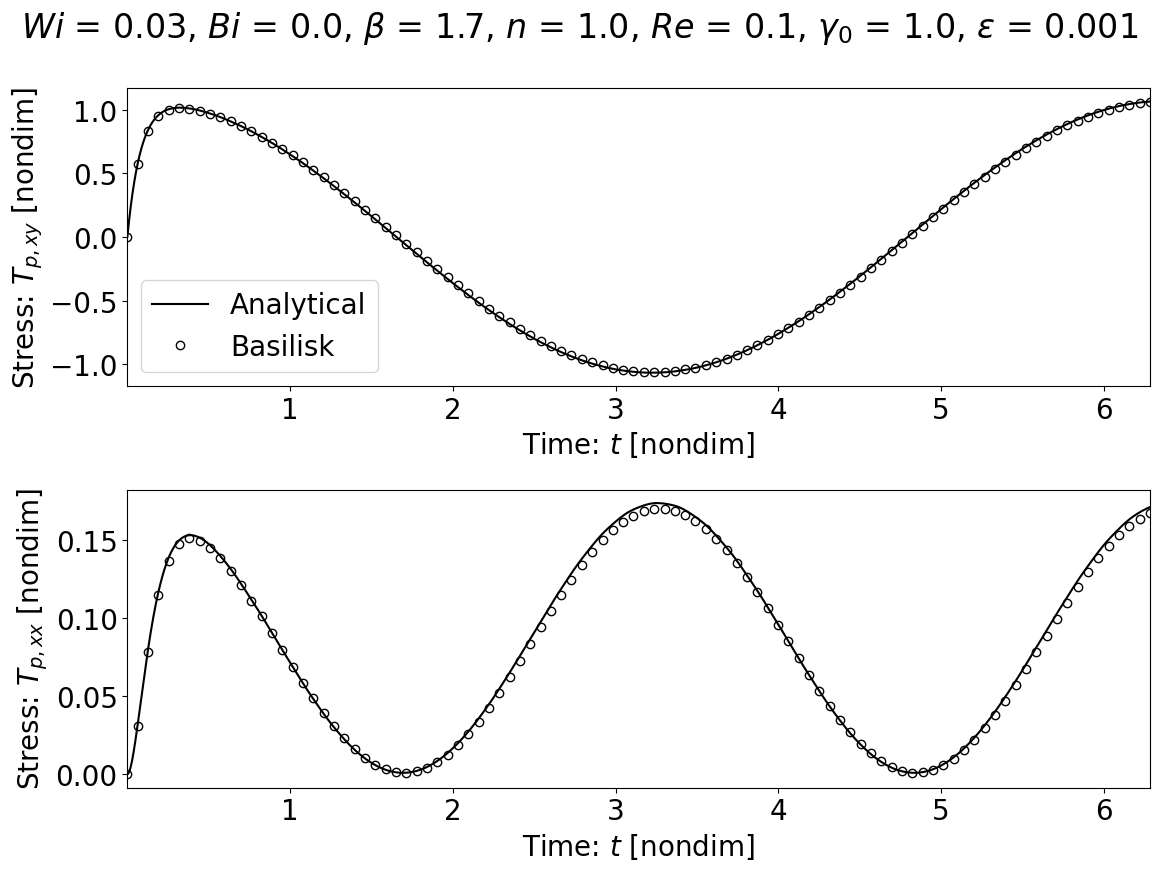

In [15]:
Wi = 0.03
Bi = 0.0
beta = 1.7
n = 1.0

Re = 0.1
reg = 1e-3
oscillatory = True
analytical_indicator = 0

amp = 1.0

base_folder = os.path.curdir + "/outputs/"

num_periods = 1

plotting(Re, reg, oscillatory, Wi, Bi, beta, n, amp, base_folder, analytical_indicator, num_periods)

Wi = 0.03, Bi = 7.272, beta = 1.7


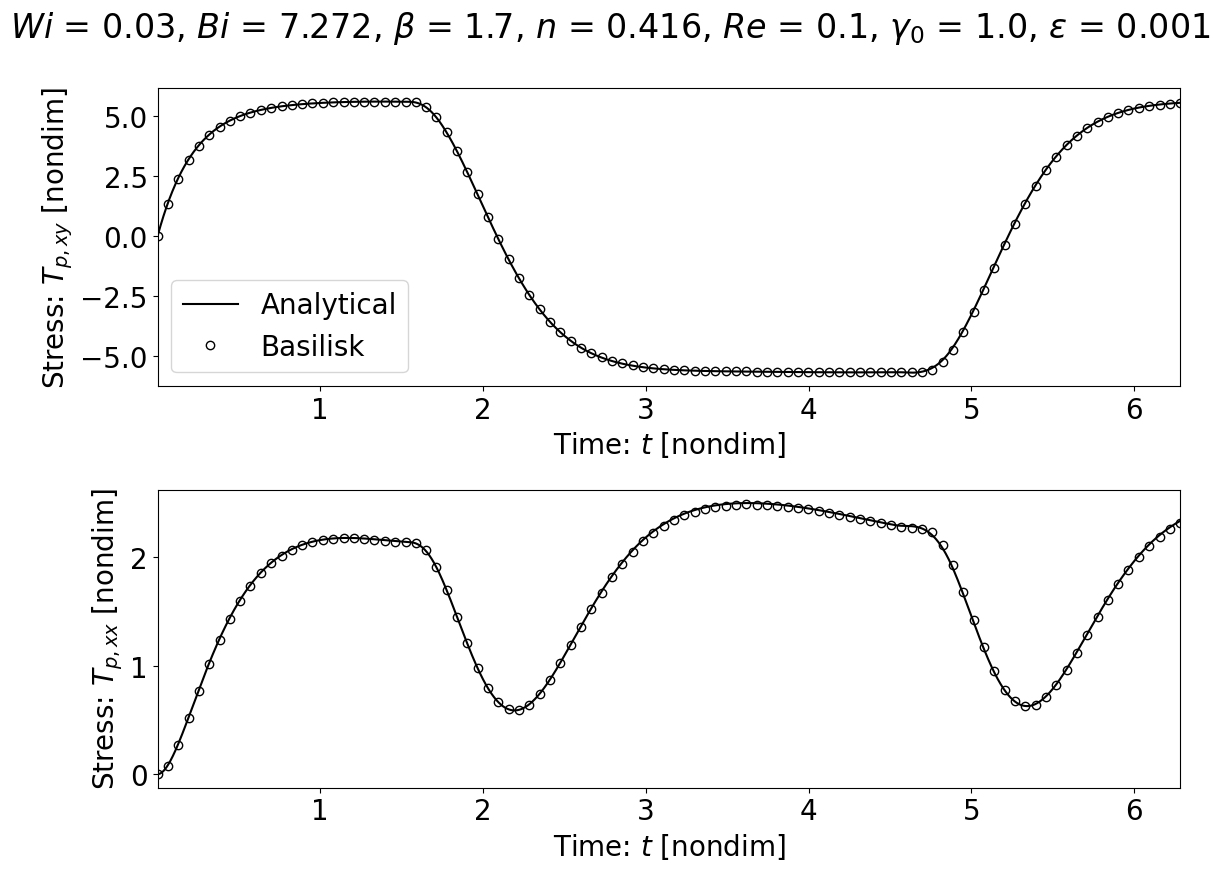

In [16]:
G = 430
eta_s = 23
tau_y = 94
k = 27.93
n = 0.416
gamma_0 = 1
omega = 0.562

Wi, Bi, beta = calculate_params(eta_s, gamma_0, omega, G, tau_y, k, n)

Re = 0.1
reg = 1e-3
oscillatory = True
analytical_indicator = 1

amp = 1.0

base_folder = os.path.curdir + "/outputs/"

num_periods = 1

plotting(Re, reg, oscillatory, Wi, Bi, beta, n, amp, base_folder, analytical_indicator, num_periods)